# Computing the nonadiabatic couplings in Kohn-Sham and excited states bases in extended tight-binding framework

In this tutorial, we will start computing the nonadiabatic couplings (NACs) from the molecular orbital overlap files obtained in [step2](../../7_step2_cp2k/2_xTB). The NACs will be computed in Kohn-Sham states but only in single-partcile (SP) excited state basis, not many-body (MB) states, because we did not perform TD-DFT. Finally we will plot the excited states energies vs time and NAC map.

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
2. [Overview of required files](#required_files)
3. [Computing the NACs](#comp_nacs)     
    3.1. [Kohn-Sham basis](#KS)\
    3.2. [Excited state basis](#excited_states)
4. [Plotting the results](#plotting)\
    4.1. [NAC distribution](#nac_dist)\
    4.2. [Energy vs time](#ene_time)\
    4.3. [NAC map](#nac_map)\
    4.4. [Average partial density of states](#ave_pdos)
    - 4.4.1. [Plot pDOS for all atoms angular momentums](#ave_pdos_1)
    - 4.4.2. [Plot pDOS for atoms with no angular momentum component](#ave_pdos_2)

### A. Learning objectives

* To be able to compute the NACs in Kohn-Sham and excited state basis
* To be able to plot the NACs distribution 
* To be able to plot the computed excited states energies vs time
* To be able to plot the NAC map
* To be able to plot the average partial density of states

### B. Use cases

* [Computing the NACs](#comp_nacs)
* [Plotting the results](#plotting)


### C. Functions

- `libra_py`
  - `data_stat`
    -  `cmat_distrib`
  - `workflows`
    - `nbra`
      - [`step3`](#comp_nacs)
        - [`run_step3_ks_nacs_libint`](#KS)
        - [`run_step3_sd_nacs_libint`](#excited_states)
  - `units`
    - `au2ev`


## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

Since the data are stored in sparse format using `scipy.sparse` library, we need to load this library so that we can read and check the orthonormality of the data.
Import `numpy`, `scipy.sparse`, `data_stat`, `data_io`, `units`, and `step3` modules. Also, `glob` will be needed to find specific types of files.

In [1]:
import os
import sys
import time
import glob
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from liblibra_core import *
from libra_py.workflows.nbra import step3
from libra_py import units, data_stat, data_io

/projects/academic/alexeyak/mohammad/software/miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/alexeyak/mohammad/software/miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/alexeyak/mohammad/software/miniconda3/envs/libra/lib/python3.6/import

## 2. Overview of required files <a name="required_files"></a>
[Back to TOC](#toc)

* `../../7_step2_cp2k/1_xTB/2_hpc/res`

The MO overlap files are needed and stored in this folder.

* `../../7_step2_cp2k/1_xTB/2_hpc/all_logfiles`

All of the logfiles obtained from the electronic structure calculations of CP2K. These files will be needed to find the Kohn-Sham HOMO index. 

## 3. Computing the NACs <a name="comp_nacs"></a>
[Back to TOC](#toc)

### 3.1. Kohn-Sham basis <a name="KS"></a>

The `libra_py.workflow.nbra.step3.run_step3_ks_nacs_libint(params)` computes the NACs between pairs of Kohn-Sham states using the molecular orbital 
overlaps. 

Libra stores the overlap data in 2-spinor format as follows:

<div>
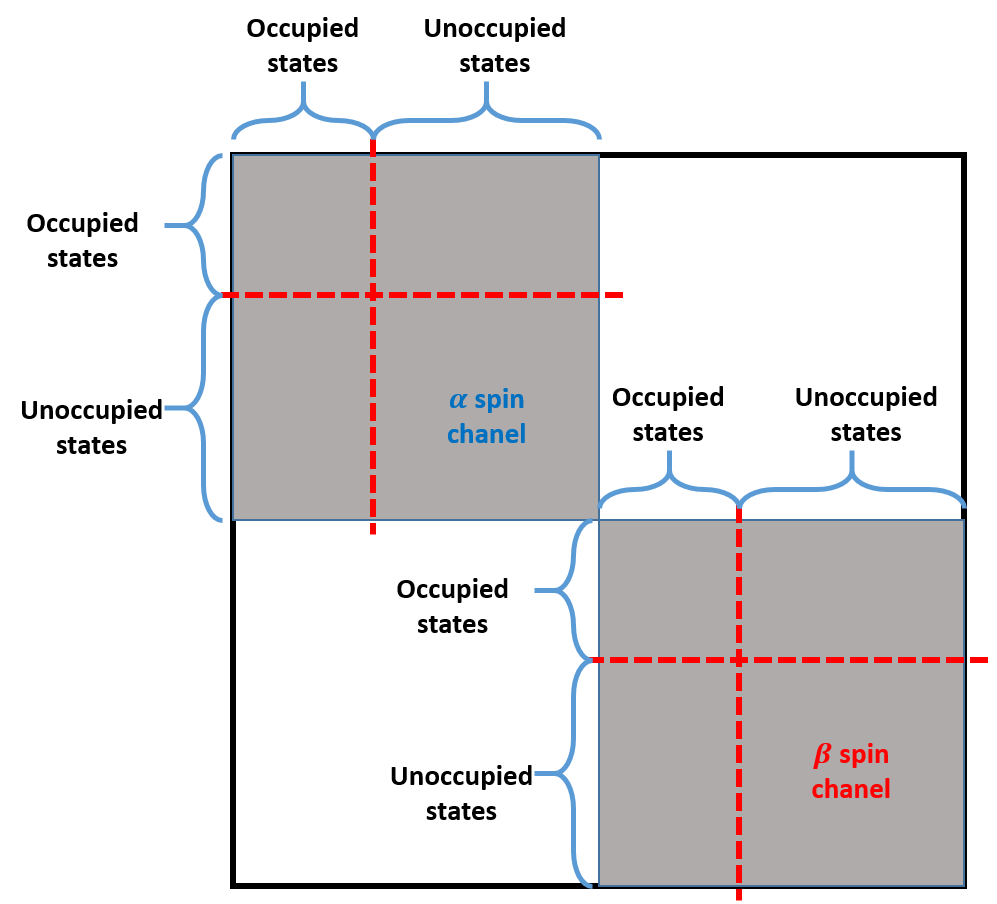
</div>

With no spin-orbit couplings, two blocks of the matrix is zero. Since most of the elements of the overlap matrices are zero, we use the `scipy.sparse` library for storing and loading them. 


The paramters for this function are as follows:

`params['lowest_orbital']`: The lowest orbital considered in the computation of the MO overlaps. This value is exactly the same
as in the `run_template.py` file in step2.

`params['highest_orbital']`: The highest orbital considered in the computation of the MO overlaps. This value is exactly the same
as in the `run_template.py` file in step2.

`params['num_occ_states']`: The number of occupied orbitals to be considered from HOMO to lower occupied states. This value is defined by user.

`params['num_unocc_states']`: The number of unoccupied orbitals to be considered from LUMO to higher unoccupied states. This value is defined by user.

The two values above are used to create an active space which then will be used to select the elements from the MO overlap and energy matrices.

`params['use_multiprocessing']`: A boolean flag to use the multiprocessing library of Python or not.

`params['nprocs']`: The number of processors to be used for the calculations. Libra will use this only if the `params['use_multiprocessing']` 
is set to `True`.

`params['time_step']`: The time-step used in the calculations in `fs`.

`params['es_software']`: The name of the software package used to compute the electronic structure calculations. This will be used to generate the HOMO 
index of that system so it can build the active space.

`params['path_to_npz_files']`: The full path to the MO overlap files.

`params['logfile_directory']`: The full path to the folder where all the log files are stored.

`params['path_to_save_ks_Hvibs']`: The full path to the folder in which the NACs between the Konh-Sham states are stored.

`params['start_time']`: The start time-step.

`params['finish_time']`: The finish time-step.

`params['apply_phase_correction']`: A boolean flag for applying phase-correction algorithm.

`params['apply_orthonormalization']`: A boolean flag for applying the orthonormalization algorithm.

`params['do_state_reordering']`: If this value is set to `1` or `2`, the state-reordering will be applied to overlap matrices.

`params['state_reordering_alpha']`: The state-reordering alpha value if the `params['do_state_reordering'] = 2`.

`params['nac_algo']`: selection of a method to compute NACs. `0` is for Hamess-Shiffer-Tully (HST), finite difference (the default) and `1` is Meek-Levine NPI approach.

After setting all the above paramters, the calculations are run using `step3.run_step3_ks_nacs_libint(params)`.

In fact, we generate a new active space from the raw data we obtained from step2, and make a new set of 
overlap matrices that some corrections are applied such as state reordering and phase-correction. Then, one can use the 
corrected overlaps for the computation of the NACs between excited states, using the `step3.run_step3_sd_nacs_libint` function. 
A schematic of the workflow for selecting new active space is shown below:

<div>
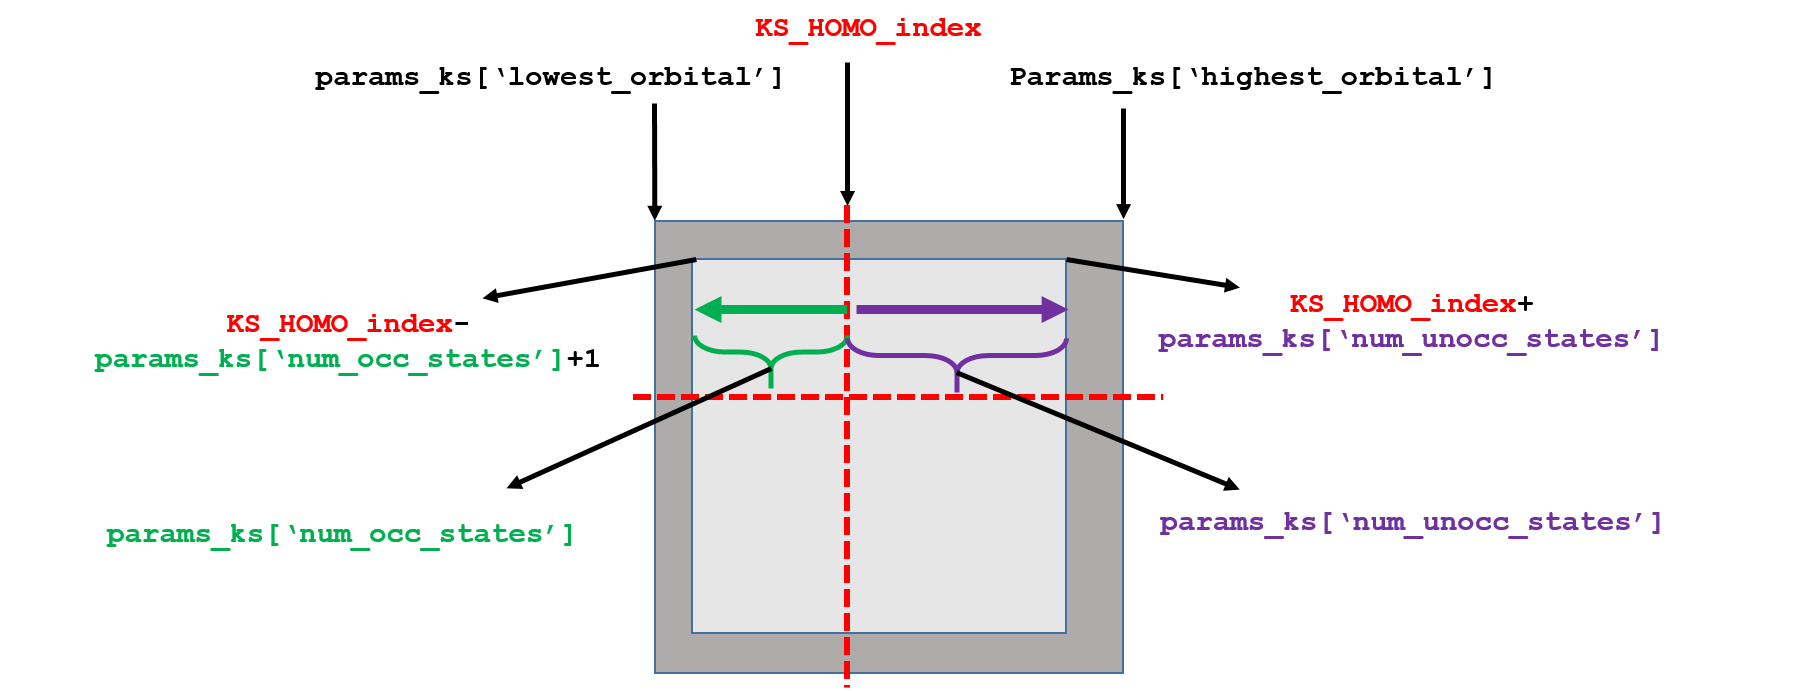
</div>


In [2]:
params_ks = {
          'lowest_orbital': 128-20, 'highest_orbital': 128+21, 'num_occ_states': 20, 'num_unocc_states': 20,
          'use_multiprocessing': True, 'nprocs': 12, 'time_step': 1.0, 'es_software': 'cp2k',
          'path_to_npz_files': os.getcwd()+'/../../7_step2_cp2k/2_xTB/2_hpc/res',
          'logfile_directory': os.getcwd()+'/../../7_step2_cp2k/2_xTB/2_hpc/all_logfiles',
          'path_to_save_ks_Hvibs': os.getcwd()+'/res-ks-xTB',
          'start_time': 1500, 'finish_time': 1700,
          'apply_phase_correction': True, 'apply_orthonormalization': True,
          'do_state_reordering': 2, 'state_reordering_alpha':0, 'nac_algo': 0
         }

#### For KS states - Applying correction to KS overlaps and computing the NACs in KS space
step3.run_step3_ks_nacs_libint(params_ks)

Computing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in step  Computing orthonormalization of St matrices in step Computing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in step     1510 15001515 15351505152015251545

1530
1540Computing orthonormalization of St matrices in step
Computing orthonormalization of St matrices in step




  
15501555

Done with step 1520 . Elapsed time: 0.8762705326080322
Computing orthonormalization of St matrices in step 1521
Done with stepDone with stepDone with step 1515   15501540. Elapsed time: . Elapsed time: Done with stepDone with step 1510Done with step  Done with step15301.0041067600250244  1500 . Elapsed time:. Elaps

  0.6233491897583008Done with step Done with step
Computing orthonormalization of St matrices in stepDone with step  15951590  Done with step . Elapsed time:1576 0.7700133323669434
Computing orthonormalization of St matrices in step 16101596 
 
15861571
Done with step. Elapsed time:
   0.39955973625183105
. Elapsed time:Computing orthonormalization of St matrices in step  16110.8366866111755371. Elapsed time:Computing orthonormalization of St matrices in step

 15660.5629661083221436  
Computing orthonormalization of St matrices in step1601 
. Elapsed time:1591 Computing orthonormalization of St matrices in step
 0.5972661972045898Done with step 1562
 Computing orthonormalization of St matrices in stepDone with step1587. Elapsed time:   161115670.4883866310119629
 
. Elapsed time:Done with step 1615
Computing orthonormalization of St matrices in step  1563. Elapsed time: 0.7179303169250488
Computing orthonormalization of St matrices in step 1616

Done with step 1571 Done with step Done

. Elapsed time:1652 Computing orthonormalization of St matrices in step0.5959181785583496 0.6892096996307373
Computing orthonormalization of St matrices in stepDone with stepDone with step   1676Done with step1671
1666 1661
Done with step 
  1657. Elapsed time:. Elapsed time:
   . Elapsed time:1642 0.599977970123291
Computing orthonormalization of St matrices in stepDone with step  1662
1627 . Elapsed time:  0.5727770328521729Computing orthonormalization of St matrices in step
 1624
Computing orthonormalization of St matrices in step 0.54610228538513180.6699564456939697
. Elapsed time: 0.5079495906829834
 Computing orthonormalization of St matrices in step Computing orthonormalization of St matrices in step 1628

1667
1643Computing orthonormalization of St matrices in step 
1672
Done with step 1632 Done with step. Elapsed time:  16470.9431488513946533 
. Elapsed time: 0.7508323192596436
Computing orthonormalization of St matrices in step 1648
Computing orthonormalization of St matrices

Applying phase-correction to step 1551
Applying phase-correction to step 1552
Applying phase-correction to step 1553
Applying phase-correction to step 1554
Applying phase-correction to step 1555
Applying phase-correction to step 1556
Applying phase-correction to step 1557
Applying phase-correction to step 1558
Applying phase-correction to step 1559
Applying phase-correction to step 1560
Applying phase-correction to step 1561
Applying phase-correction to step 1562
Applying phase-correction to step 1563
Applying phase-correction to step 1564
Applying phase-correction to step 1565
Applying phase-correction to step 1566
Applying phase-correction to step 1567
Applying phase-correction to step 1568
Applying phase-correction to step 1569
Applying phase-correction to step 1570
Applying phase-correction to step 1571
Applying phase-correction to step 1572
Applying phase-correction to step 1573
Applying phase-correction to step 1574
Applying phase-correction to step 1575
Applying phase-correction

### 3.2. Excited state basis <a name="excited_states"></a>

The NACs can also be computed between excited states. These include the single-particle and many-body bases which the latter is obtained from the
TD-DFT calculations. First, we need to compute the overlap between excited state Slater-determinants (SDs) then they will be used to compute the NACs
between them. For many-body states, the configuration interaction coefficietns will also be used. We will consider both single-particle 
and many-body for DFT calculations but only single-particle for xTB.

To run the calculations `step3.run_step3_sd_nacs_libint(params)` function will be used. Some parameters are common with the ones used to run `step3.run_step3_ks_nacs_libint(params)`.

There are different ways of defining the excited states SDs (the single-particle excited state basis). The first is through 
defining the `num_occ_states` and `num_unocc_states` in which Libra
will start making the SDs from all of the occupied states (starting from `HOMO-num_occ_states+1`) to all of the unoccupied states (ends
to `LUMO+num_unocc_states-1`). Also, if the unrestricted spin calculation flag is set to `True`, the SDs will be made for both alpha and beta spin channels. 

For example, if you want to build the electron-only excitation basis, you need to set `params['num_occ_states'] = 1` and set `params['num_unocc_states']`
to a value less than the number of unoccupied orbitals that was considered in the computation of overlaps. This will generate all the electron-only
excitation from HOMO to unoccupied states.

If the TD-DFT calculations has been done, then Libra will go over all log files and 
generate all the SDs used for all the steps and therefore the definition of these SDs is automatic and Libra will replace the `num_occ_states` and
`num_unocc_states` itself based on the SDs that were generated from the TD-DFT log files. 



Other parameters needed to run the `step3.run_step3_sd_nacs_libint(params)` function are as follows:

`params['isUKS']`: A boolean flag for unrestricted spin calculations.

`params['is_many_body']`: If set to `True`, the NACs will be computed between pairs of many-body (TD-DFT) states. Also, the NACs between single-particle 
SDs obtained from the TD-DFT results will be computed as well. Otherwise, only single-particle NACs will be computed only for the SDs obtained from
`num_occ_states` and `num_unocc_states`. This will be used for xTB calculations in which no TD-DFT is performed.

`params['number_of_states']`: The number of TD-DFT states to consider. This value should not exceed the number of requested TD-DFT states in the CP2K
calculations.

`params['tolerance']`: A lower bound for selection of the excitation with configuration interaction coefficients higher than this value.

`params['verbosity']`: An integer value showing the printing level. The default is set to 0. Higher values will print more data on terminal.

`params['sorting_type']`: After defining the SDs, Libra will sort them either based on `'energy'` or `'identity'`.



In this example, we use the corrected KS time-overlaps that we generated above in the `res-ks-xTB` directory. For single-particle basis, `is_many_body` is set to `False` and Libra will generate all the single-particle excitations from all the occupied states from HOMO to `HOMO-params['num_occ_states']+1` states to all `HOMO+params['num_unocc_states']` unoccupied states which counts to a total number of excitations of `params['num_occ_states'] x params['num_unocc_states']`.


<div>
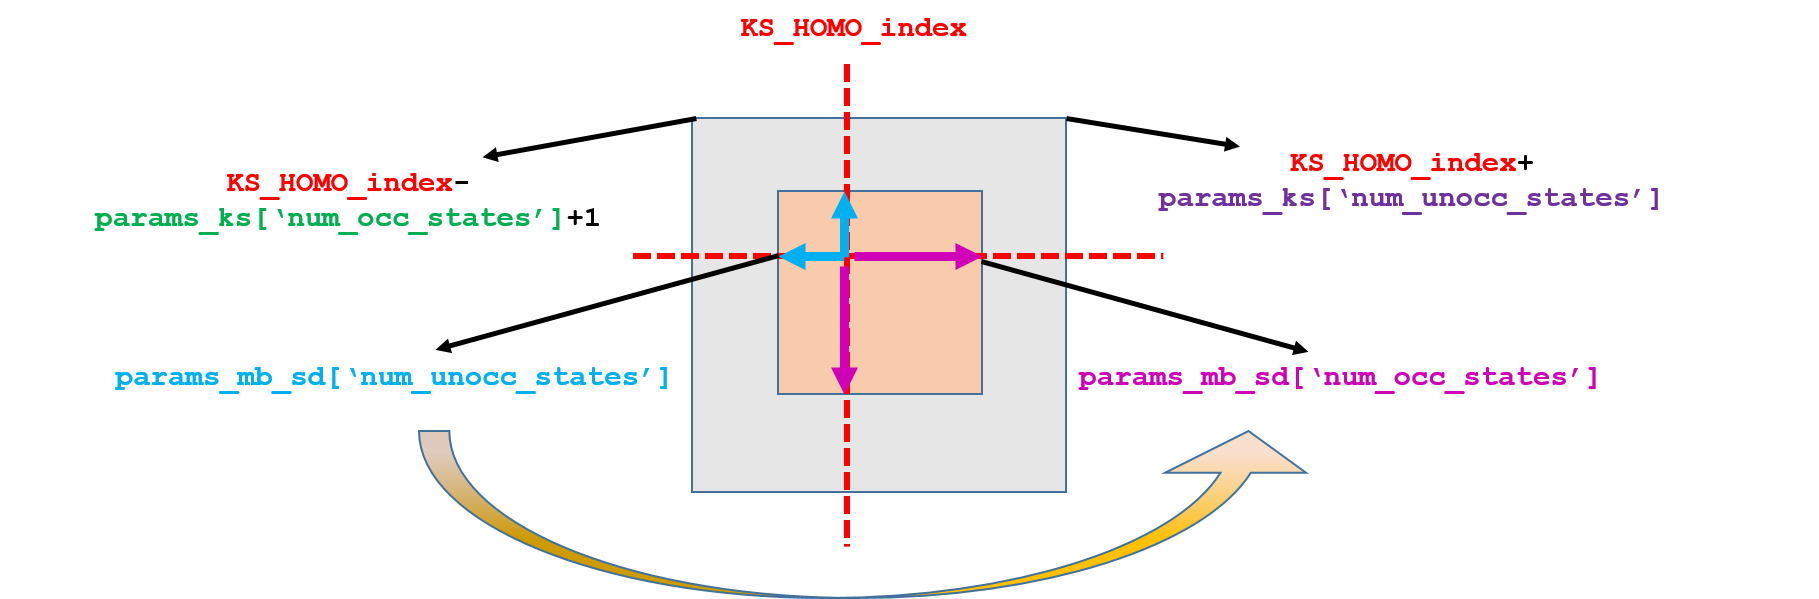
</div>

Note that here the KS HOMO index is 128.

In [3]:
#### For excited states - Computing the excited states SDs and their overlaps and NACs
params_mb_sd = {
          'lowest_orbital': 128-params_ks['num_occ_states']+1, 'highest_orbital': 128+params_ks['num_unocc_states'],
          'num_occ_states': 10, 'num_unocc_states': 10,
          'isUKS': 0, 'number_of_states': 1, 'tolerance': 0.01, 'verbosity': 0,
          'use_multiprocessing': True, 'nprocs': 8,
          'is_many_body': False, 'time_step': 1.0, 'es_software': 'cp2k',
          'path_to_npz_files': os.getcwd()+'/res-ks-xTB',
          'logfile_directory': os.getcwd()+'/../../7_step2_cp2k/2_xTB/2_hpc/all_logfiles',
          'path_to_save_sd_Hvibs': os.getcwd()+'/res-mixed-basis-xTB',
          'outdir': os.getcwd()+'/res-mixed-basis-xTB',
          'start_time': 1500, 'finish_time': 1700, 'sorting_type': 'identity',
          'apply_phase_correction': True, 'apply_orthonormalization': True,
          'do_state_reordering': 2, 'state_reordering_alpha':0, 'nac_algo': 0
         }


step3.run_step3_sd_nacs_libint(params_mb_sd)

sd_unique_basis is: [[[1, 11], 'alp'], [[1, 12], 'alp'], [[1, 13], 'alp'], [[1, 14], 'alp'], [[1, 15], 'alp'], [[1, 16], 'alp'], [[1, 17], 'alp'], [[1, 18], 'alp'], [[1, 19], 'alp'], [[1, 20], 'alp'], [[2, 11], 'alp'], [[2, 12], 'alp'], [[2, 13], 'alp'], [[2, 14], 'alp'], [[2, 15], 'alp'], [[2, 16], 'alp'], [[2, 17], 'alp'], [[2, 18], 'alp'], [[2, 19], 'alp'], [[2, 20], 'alp'], [[3, 11], 'alp'], [[3, 12], 'alp'], [[3, 13], 'alp'], [[3, 14], 'alp'], [[3, 15], 'alp'], [[3, 16], 'alp'], [[3, 17], 'alp'], [[3, 18], 'alp'], [[3, 19], 'alp'], [[3, 20], 'alp'], [[4, 11], 'alp'], [[4, 12], 'alp'], [[4, 13], 'alp'], [[4, 14], 'alp'], [[4, 15], 'alp'], [[4, 16], 'alp'], [[4, 17], 'alp'], [[4, 18], 'alp'], [[4, 19], 'alp'], [[4, 20], 'alp'], [[5, 11], 'alp'], [[5, 12], 'alp'], [[5, 13], 'alp'], [[5, 14], 'alp'], [[5, 15], 'alp'], [[5, 16], 'alp'], [[5, 17], 'alp'], [[5, 18], 'alp'], [[5, 19], 'alp'], [[5, 20], 'alp'], [[6, 11], 'alp'], [[6, 12], 'alp'], [[6, 13], 'alp'], [[6, 14], 'alp'], [[6, 15

Done with sorting and computing the SDs energies. Elapsed time: 6.053532838821411
Computing the SD overlaps for step0 Computing the SD overlaps for stepComputing the SD overlaps for step 
7 Computing the SD overlaps for step
14Computing the SD overlaps for step 
21Computing the SD overlaps for stepComputing the SD overlaps for step
   Computing the SD overlaps for step283542 


49
Applying orthonormalization for SDs for step 49
Applying orthonormalization for SDs for step 21
Applying orthonormalization for SDs for step 7
Applying orthonormalization for SDs for step 28
Applying orthonormalization for SDs for step 35
Applying orthonormalization for SDs for step 0
Applying orthonormalization for SDs for step 14
Applying orthonormalization for SDs for step 42
Done with computing the SD overlap of step 42. Elapsed time 1.1476616859436035Done with computing the SD overlap of step 0. Elapsed time 1.1507079601287842Done with computing the SD overlap of step 49. Elapsed time 1.1429121494293213D

Applying orthonormalization for SDs for stepApplying orthonormalization for SDs for stepDone with computing the SD overlap of step 55. Elapsed time 1.2262392044067383  13
34

Computing the SD overlaps for step 56
Done with computing the SD overlap of step 34. Elapsed time 1.1777191162109375
Done with computing the SD overlap of step 13. Elapsed time 1.2890324592590332Computing the SD overlaps for step
 63
Computing the SD overlaps for stepApplying orthonormalization for SDs for step  7026

Done with computing the SD overlap of step 26. Elapsed time 1.0756590366363525
Applying orthonormalization for SDs for step Computing the SD overlaps for step 4127

Applying orthonormalization for SDs for step 6
Done with computing the SD overlap of step 41. Elapsed time 1.5397109985351562
Computing the SD overlaps for step 77
Done with computing the SD overlap of step 6. Elapsed time 1.015321969985962
Computing the SD overlaps for step 84
Applying orthonormalization for SDs for step 48
Applying orth

Computing the SD overlaps for stepApplying orthonormalization for SDs for step  9562

Applying orthonormalization for SDs for stepApplying orthonormalization for SDs for step  103
82
Done with computing the SD overlap of step 95. Elapsed time 1.4645905494689941
Computing the SD overlaps for step 96
Done with computing the SD overlap of step 82. Elapsed time 0.9767582416534424
Done with computing the SD overlap of step 103. Elapsed time 1.0955555438995361Computing the SD overlaps for step 
83Computing the SD overlaps for step
 104
Applying orthonormalization for SDs for step 68
Applying orthonormalization for SDs for step 89
Done with computing the SD overlap of step 89. Elapsed time 0.9205570220947266
Computing the SD overlaps for step 90
Done with computing the SD overlap of step 68. Elapsed time 1.5880286693572998
Computing the SD overlaps for step 69
Applying orthonormalization for SDs for step 76
Done with computing the SD overlap of step 76. Elapsed time 1.3658287525177002
Computi

Computing the SD overlaps for step 117
Applying orthonormalization for SDs for step 144
Applying orthonormalization for SDs for stepDone with computing the SD overlap of step 144. Elapsed time 1.1849288940429688 
Computing the SD overlaps for step137 
145
Done with computing the SD overlap of step 137. Elapsed time 1.3894529342651367
Computing the SD overlaps for step 138
Applying orthonormalization for SDs for step 117
Done with computing the SD overlap of step 117. Elapsed time 0.68739914894104Applying orthonormalization for SDs for stepApplying orthonormalization for SDs for step
Computing the SD overlaps for step 131
  118
Applying orthonormalization for SDs for step 158
124
Applying orthonormalization for SDs for step 164
Done with computing the SD overlap of step 158. Elapsed time 1.0555775165557861
Computing the SD overlaps for step Done with computing the SD overlap of step 131. Elapsed time 1.3136177062988281159

Done with computing the SD overlap of step 164. Elapsed time 1.4

Done with computing the SD overlap of step 174. Elapsed time 0.7152271270751953
Applying orthonormalization for SDs for step 188
Applying orthonormalization for SDs for step 181
Applying orthonormalization for SDs for step 195
Done with computing the SD overlap of step 181. Elapsed time 0.7383122444152832
Done with computing the SD overlap of step 188. Elapsed time 0.9721357822418213
Done with computing the SD overlap of step 195. Elapsed time 0.8020215034484863
Done with computing the SD overlaps. Elapsed time: 33.51218605041504
Applying state-reordering to SDs overlaps...

Done with state-reordering of SDs. Elapsed time: 19.230223655700684
Applying phase-correction to St_sd matrix of step 0
Applying phase-correction to St_sd matrix of step 1
Applying phase-correction to St_sd matrix of step 2
Applying phase-correction to St_sd matrix of step 3
Applying phase-correction to St_sd matrix of step 4
Applying phase-correction to St_sd matrix of step 5
Applying phase-correction to St_sd mat

Applying phase-correction to St_sd matrix of step 145
Applying phase-correction to St_sd matrix of step 146
Applying phase-correction to St_sd matrix of step 147
Applying phase-correction to St_sd matrix of step 148
Applying phase-correction to St_sd matrix of step 149
Applying phase-correction to St_sd matrix of step 150
Applying phase-correction to St_sd matrix of step 151
Applying phase-correction to St_sd matrix of step 152
Applying phase-correction to St_sd matrix of step 153
Applying phase-correction to St_sd matrix of step 154
Applying phase-correction to St_sd matrix of step 155
Applying phase-correction to St_sd matrix of step 156
Applying phase-correction to St_sd matrix of step 157
Applying phase-correction to St_sd matrix of step 158
Applying phase-correction to St_sd matrix of step 159
Applying phase-correction to St_sd matrix of step 160
Applying phase-correction to St_sd matrix of step 161
Applying phase-correction to St_sd matrix of step 162
Applying phase-correction to

## 4. Plotting the results <a name='plotting'></a>
[Back to TOC](#toc)

### 4.1. NAC distribution <a name='nac_dist'></a>

One of the intuitive ways to visualize the NACs is to plot the distribution of the NACs. Here we plot them for SP and MB excited states.

<IPython.core.display.Javascript object>


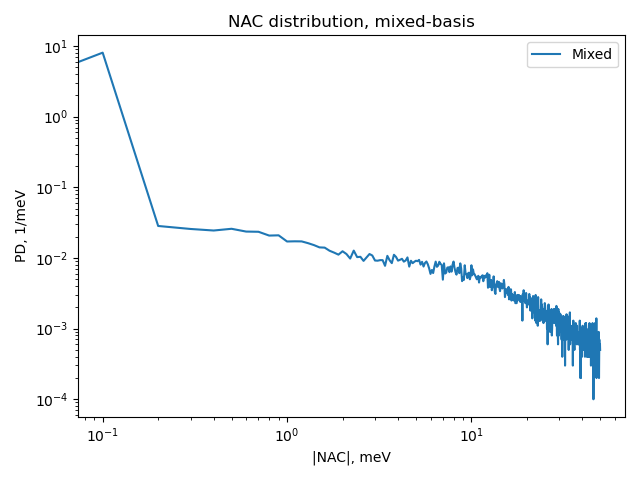

In [15]:
%matplotlib notebook

for basis in ['sd']:
    nac = []
    nac_files = glob.glob(F'res-mixed-basis-xTB/Hvib_{basis}*im*')
    for nac_file in nac_files:
        hvib = sp.load_npz(nac_file)
        hvib_dense = hvib.todense().real
        for i in range(hvib.shape[0]):
            for j in range(hvib.shape[0]):
                if j != i:
                    nac_ij = np.abs(hvib_dense[i,j])* 1000.0 * units.au2ev
                    x_mb = MATRIX(1,1)
                    x_mb.set(0, 0, nac_ij )
                    nac.append( x_mb )
    bin_supp, dens, cum = data_stat.cmat_distrib( nac, 0, 0, 0, 0, 50, 0.1)
    plt.plot( bin_supp, dens, label='Mixed')
plt.xlabel('|NAC|, meV')
plt.ylabel('PD, 1/meV')
plt.title('NAC distribution, mixed-basis')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
# plt.savefig('nac_dist_1.jpg', dpi=600)

### 4.2. Energy vs time <a name='ene_time'></a>
Here, we plot the excited states energy vs time. Since the excited states were sorted by their `'identity'` it is easy to visualize the states energies crossings.

<IPython.core.display.Javascript object>


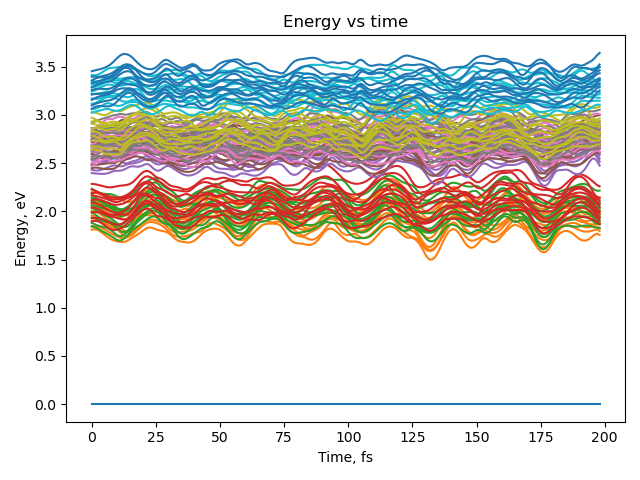

In [7]:
%matplotlib notebook
energy_files = glob.glob('res-mixed-basis-xTB/Hvib_sd*re*')
energy_files = data_io.sort_hvib_file_names(energy_files)
#print('Sorted energy files are:', energy_files)
dt = 1.0 # fs
energies = []
for file in energy_files:
    energies.append(np.diag(sp.load_npz(file).todense().real))
energies = np.array(energies)*units.au2ev
md_time = np.arange(0,energies.shape[0]*dt,dt)
#print(energies.shape)
for i in range(energies.shape[1]):
    plt.plot(md_time, energies[:,i]-energies[:,0])
plt.title('Energy vs time')
plt.ylabel('Energy, eV')
plt.xlabel('Time, fs')
plt.tight_layout()

### 4.3. NAC map <a name='nac_map'></a>
Another way of visualizing the NAC values is to plot the average NAC matrix using `plt.imshow`.

<IPython.core.display.Javascript object>


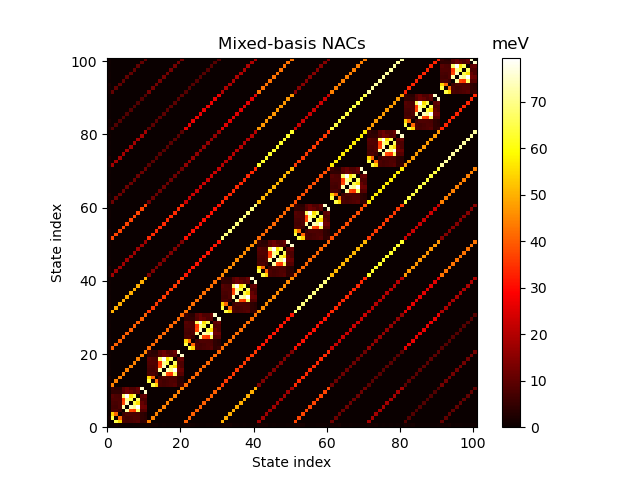

Text(0.5, 1.0, 'Mixed-basis NACs')

In [8]:
%matplotlib notebook
nac_files = glob.glob('res-mixed-basis-xTB/Hvib_sd*im*')
for c, nac_file in enumerate(nac_files):
    nac_mat = sp.load_npz(nac_file).todense().real
    if c==0:
        nac_ave = np.zeros(nac_mat.shape)
    nac_ave += np.abs(nac_mat)
nac_ave *= 1000*units.au2ev/c
nstates = nac_ave.shape[0]
plt.imshow(np.flipud(nac_ave), cmap='hot', extent=(0,nstates,0,nstates))#, vmin=0, vmax=150)
plt.xlabel('State index')
plt.ylabel('State index')
plt.colorbar().ax.set_title('meV')
plt.title('Mixed-basis NACs')

### 4.4. Average partial density of states <a name='ave_pdos'></a>
In this section, we will plot the average partial density of states (pDOS) over the MD trajectory. There are two ways to take the average of the pDOS:

1- Average all the pDOS files and then convolve the average pDOS for each element.
2- Convolve the pDOS files and then take the average for each element.

We choose the first one due to two reasons. First, the computational cost is much lower and we only need one convolution. Second is that averaging over the grid points (using the method 2) is dependent on the number of grid points we use for convolution which again adds to the complexity of the procedure. 

Here, we will use normalized Gaussian function for weighting the pDOS values and summing them.

$$f(x)=\frac{1}{\sigma\sqrt{2\pi}}\exp(-\frac{(x-\mu)^2}{2\sigma^2})$$

This function is defined in the `gaussian_function` below. To apply this to a vector of numbers and sum all the weighted Gaussians, we use the `gaussian_function_vector` which will be used for pDOS plots.

In [9]:
def gaussian_function(a, mu, sigma, num_points, x_min, x_max):
    pre_fact = (a/sigma)/(np.sqrt(2*np.pi))
    x = np.linspace(x_min, x_max, num_points)
    x_input = np.array((-1/2)/(np.square(sigma))*np.square(x-mu))
    gaussian_fun = pre_fact*np.exp(x_input)
    
    return x, gaussian_fun
    
def gaussian_function_vector(a_vec, mu_vec, sigma, num_points, x_min, x_max):
    for i in range(len(a_vec)):
        if i==0:
            sum_vec = np.zeros(num_points)
        energy_grid, conv_vec = gaussian_function(a_vec[i], mu_vec[i], sigma, num_points, x_min, x_max)
        sum_vec += conv_vec
    return energy_grid, sum_vec


#### 4.4.1. Plot pDOS for all atoms angular momentums <a name='ave_pdos_1'></a>

In this part, we plot the pDOS for all of the angular momentum components of each atom. This is done by using the `orbital_cols`. In fact, the `orbital_cols` is related to `orbitals`. For example, for `s` orbital, we consider the 3rd index and for `p` orbital, we sum the columns from 4 to 6 (`range(4,7)`). Here we want to show how the code works and how the you can modify that based on your project. In the next section, we will show the pDOS only for atoms and sum all the components in each row of the pdos file. Other parameters are as follows:

`atoms`: The atoms names which will be used in the labeling and plotting. The atoms order should be exactly the same as appear in the `.pdos` files. For example, the `*k1*.pdos` files contain the pDOS data for `N` atom and `*k2*.pdos` files contain the data for the `N` atom.

`npoints`: The number of grid points for making the Gaussian functions. Note that, this value should be more than the number of states in the `.pdos` files.

`sigma`: The standard deviation in eV.

`shift`: This value shifts the minimum and maximum energy found in the `pdos_ave` and will extend the boundaries from both sides by `shift`eV.

Finally, we will plot the total density of states. Note that the HOMO energy level is set to zero.

<IPython.core.display.Javascript object>


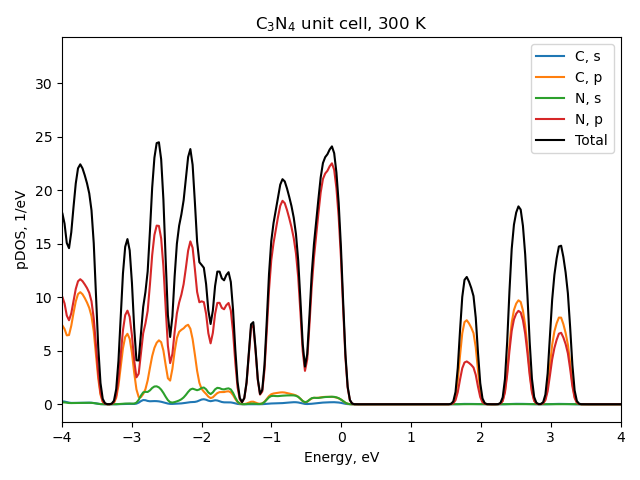

In [10]:
%matplotlib notebook
path_to_all_pdos = os.getcwd()+'/../../7_step2_cp2k/2_xTB/2_hpc/all_pdosfiles'
atoms = ['C', 'N']
orbitals_cols = [[3], range(4,7), range(7,12), range(12,19)]
orbitals = ['s','p','d','f']
npoints = 1000
sigma = 0.05 # eV
shift = 2.0 # eV
ave_pdos_convolved_all = []
for c1,i in enumerate([1,2]):
    pdos_files = glob.glob(path_to_all_pdos+F'/*k{i}*.pdos')
    for c2, pdos_file in enumerate(pdos_files):
        pdos_mat = np.loadtxt(pdos_file)
        if c2==0:
            pdos_ave = np.zeros(pdos_mat.shape)
        pdos_ave += pdos_mat
    pdos_ave /= c2+1
    pdos_ave[:,1] *= units.au2ev
    e_min = np.min(pdos_ave[:,1])-shift
    e_max = np.max(pdos_ave[:,1])+shift
    homo_level = np.max(np.where(pdos_ave[:,2]==2.0))
    homo_energy = pdos_ave[:,1][homo_level]
    for c3, orbital_cols in enumerate(orbitals_cols):
        try:
            sum_pdos_ave = np.sum(pdos_ave[:,orbital_cols],axis=1)
            ave_energy_grid, ave_pdos_convolved = gaussian_function_vector(sum_pdos_ave, pdos_ave[:,1], sigma,
                                                                               npoints, e_min, e_max)
            ave_pdos_convolved_all.append(ave_pdos_convolved)
            pdos_label = atoms[c1]+F', {orbitals[c3]}'
            plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved, label=pdos_label)
        except:
            pass


ave_pdos_convolved_total = np.sum(np.array(ave_pdos_convolved_all),axis=0)
plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved_total, color='black', label='Total')
plt.legend()
plt.xlim(-4,4)
plt.ylabel('pDOS, 1/eV')
plt.xlabel('Energy, eV')
plt.title('C$_3$N$_4$ unit cell, 300 K')
plt.tight_layout()

#### 4.4.2. Plot pDOS for atoms with no angular momentum component <a name='ave_pdos_2'></a>
As you can see we have removed the `for` loop for the `orbital_cols` and in the `try` section we have set `sum_pdos_ave = np.sum(pdos_ave[:,3::],axis=1)` which will sum all the columns from 3rd index (`pdos_ave[:,3::]`).

<IPython.core.display.Javascript object>


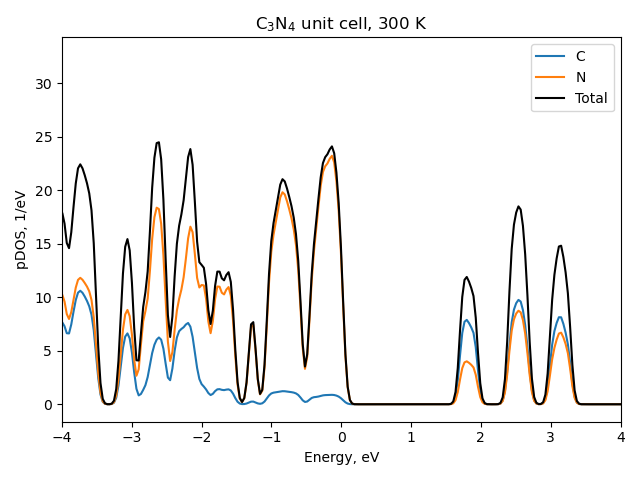

In [13]:
%matplotlib notebook
path_to_all_pdos = os.getcwd()+'/../../7_step2_cp2k/2_xTB/2_hpc/all_pdosfiles'
atoms = ['C', 'N']
npoints = 1000
sigma = 0.05
shift = 2.0 # eV
ave_pdos_convolved_all = []
for c1,i in enumerate([1,2]):
    pdos_files = glob.glob(path_to_all_pdos+F'/*k{i}*.pdos')
    for c2, pdos_file in enumerate(pdos_files):
        pdos_mat = np.loadtxt(pdos_file)
        if c2==0:
            pdos_ave = np.zeros(pdos_mat.shape)
        pdos_ave += pdos_mat
    pdos_ave /= c2+1
    pdos_ave[:,1] *= units.au2ev
    e_min = np.min(pdos_ave[:,1])-shift
    e_max = np.max(pdos_ave[:,1])+shift
    homo_level = np.max(np.where(pdos_ave[:,2]==2.0))
    homo_energy = pdos_ave[:,1][homo_level]
    try:
        sum_pdos_ave = np.sum(pdos_ave[:,3::],axis=1)
        ave_energy_grid, ave_pdos_convolved = gaussian_function_vector(sum_pdos_ave, pdos_ave[:,1], sigma,
                                                                           npoints, e_min, e_max)
        ave_pdos_convolved_all.append(ave_pdos_convolved)
        pdos_label = atoms[c1]
        plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved, label=pdos_label)
    except:
        pass


ave_pdos_convolved_total = np.sum(np.array(ave_pdos_convolved_all),axis=0)
plt.plot(ave_energy_grid-homo_energy, ave_pdos_convolved_total, color='black', label='Total')
plt.legend()
plt.xlim(-4,4)
plt.ylabel('pDOS, 1/eV')
plt.xlabel('Energy, eV')
plt.title('C$_3$N$_4$ unit cell, 300 K')
plt.tight_layout()